In [1]:
import pandas as pd
import allel
import numpy as np
import seaborn as sns

In [2]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')

import pickle
with open('../key_files/blocks_snpsid_dict.pkl', 'rb') as f:
    dict_blocks = pickle.load(f)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

snps_names = snps_names[snps_names['total_alleles05filter_firstgen'].notna()].reset_index(drop=True)

In [3]:
clim1001 = pd.read_csv('../key_files/1001g_regmap_grenet_ecotype_info_corrected_bioclim_2024May16.csv')

clim1001['ecotypeid'] = clim1001['ecotypeid'].astype(str)


In [5]:
founder_ecotypes = pd.read_csv('../key_files/founder_ecotype_names.csv')['0'].values

In [6]:
vcfgrene = allel.read_vcf('../gwas/greneNet_final_v1.1.recode.vcf.gz')


KeyboardInterrupt



In [ ]:
#vcfgrene = allel.read_vcf('../gwas/1001g/1001g_grenet_climate.recode.vcf')
geno = vcfgrene['calldata/GT']

geno = geno.sum(axis=2)

geno = pd.DataFrame(geno)

geno.columns = vcfgrene['samples']

grene_chrom_pos = pd.DataFrame({'chrom': vcfgrene['variants/CHROM'], 'pos': vcfgrene['variants/POS']})

#vcfgrene = pd.concat([grene_chrom_pos, geno],axis=1)

In [ ]:
clim1001 = clim1001[clim1001['ecotypeid'].isin(geno.columns)]

In [120]:
clim1001 = clim1001[clim1001['ecotypeid'].isin(founder_ecotypes.astype(str))]

In [122]:
clim1001 = clim1001[['ecotypeid', 'bio1']]

In [123]:
clim1001['ecotypeid'] = clim1001['ecotypeid'].astype(str)

/tmp/ipykernel_649045/689236628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim1001['ecotypeid'] = clim1001['ecotypeid'].astype(str)


In [124]:
clim1001_dict = clim1001.set_index('ecotypeid')['bio1'].to_dict()

In [126]:
clim1001 = clim1001.set_index('ecotypeid')

In [ ]:
geno = geno.T

In [ ]:
geno = geno.sort_index()

In [ ]:
order_ecotypes = geno.index

In [128]:
clim1001 = clim1001.sort_index()

In [ ]:
geno = geno.reset_index(drop=True)

In [129]:
clim1001 = clim1001.reset_index(drop=True)

In [ ]:
clim1001 = np.array(clim1001)

temperature_centered = clim1001 - np.mean(clim1001)

snp_temperature_association = np.array(geno).T.dot(np.array(temperature_centered))

snp_temperature_association /= len(clim1001)

snp_temperature_association = pd.Series(snp_temperature_association.flatten())

<Axes: ylabel='Count'>

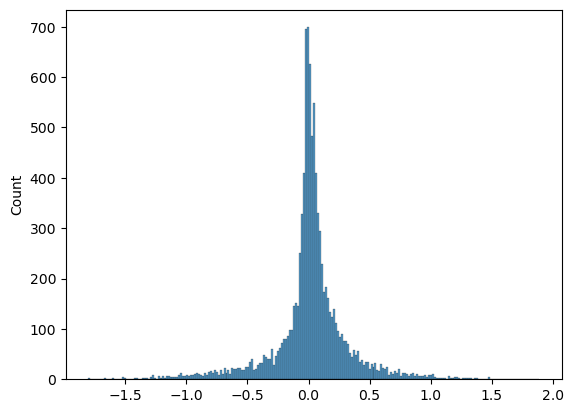

In [79]:
sns.histplot(pd.Series(snp_temperature_association).sample(10000))

In [80]:
snp_origin_bio1 = pd.DataFrame({'chrom': vcfgrene['variants/CHROM'], 'pos': vcfgrene['variants/POS'], 'snp_origin_bio1': snp_temperature_association})

In [23]:
#snp_origin_bio1.to_csv('../key_files/snp_origin_bio1_1001gvcf.csv',index=None)

In [23]:
#grene_chrom_pos.sort_values('snp_origin_bio1')

In [82]:
#snp_origin_bio1.to_csv('../key_files/snp_origin_bio1_grenenetvcf.csv',index=None)

In [ ]:
## approxiamtion of block orgins 

In [152]:
snp_origin_bio1['id'] = snp_origin_bio1['chrom'].astype(str) + '_' + snp_origin_bio1['pos'].astype(str)

In [153]:
snp_origin_bio1['blocks'] = snp_origin_bio1['id'].map(reverse_mapping)

In [156]:
block_origin_bio1 = snp_origin_bio1.groupby('blocks')['snp_origin_bio1'].mean().reset_index()

In [157]:
#block_origin_bio1.to_csv('../key_files/block_origin_bio1_grenenetvcf_ogscale.csv',index=None)

In [7]:
snp_origin_bio1 = pd.read_csv('../key_files/snp_origin_bio1_1001gvcf.csv')

dict_snps = pd.read_csv('../key_files/var_pos_grenenet.csv')

snp_origin_bio1 = pd.concat([dict_snps['id'], snp_origin_bio1],axis=1)

In [8]:
snp_origin_bio1['snp_origin_bio1'] = snp_origin_bio1['snp_origin_bio1'] + 9.584559885454384

In [13]:
binomial_reg = pd.read_csv('../binomial_regression_lastgen/binomial_reg_lastgen_wmaf_bio1.csv')

In [14]:
#binomial_reg = pd.read_csv('../binomial_regression_lastgen/binomial_reg_results_last_gen.csv')

binomial_reg_id = dict_snps[dict_snps['total_alleles05filter_lastgen'].notna()]['id'].reset_index(drop=True)

binomial_reg = pd.concat([binomial_reg, binomial_reg_id],axis=1)

snp_origin_beta_binomial_reg = snp_origin_bio1.merge(binomial_reg)

<Axes: xlabel='slope', ylabel='Count'>

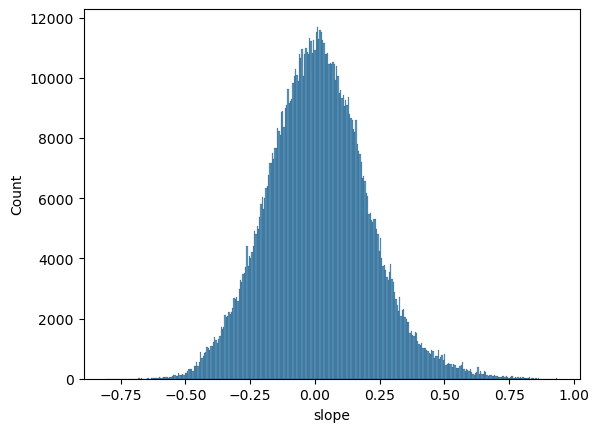

In [11]:
sns.histplot(snp_origin_beta_binomial_reg['slope'])

In [23]:
#### calcualte teh correlation on ld pruned allele

vcfgrene = allel.read_vcf('../key_files/greneNet_final_v1.1_LDpruned.recode.vcf')

In [28]:
variants_ld_prunned = vcfgrene['variants/ID']

In [32]:
snp_origin_beta_binomial_reg_ldp = snp_origin_beta_binomial_reg[snp_origin_beta_binomial_reg['id'].isin(variants_ld_prunned)]

In [33]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(snp_origin_beta_binomial_reg_ldp['snp_origin_bio1'], snp_origin_beta_binomial_reg_ldp['slope'])

In [ ]:
import matplotlib.pyplot as plt

In [138]:
0.05/len(snp_origin_beta_binomial_reg)

4.768103296189809e-08

In [139]:
sign = snp_origin_beta_binomial_reg[snp_origin_beta_binomial_reg['pvalue'] < 4.768103296189809e-08]

In [140]:
sign['log_pvalue'] = np.log(sign['pvalue'])

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_649045/3637229368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sign['log_pvalue'] = np.log(sign['pvalue'])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm

In [143]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

In [144]:
import matplotlib.colors as mcolors
font_size = 12

In [ ]:
## launc wza on the binomial reg across sites 

In [37]:
wza_binomial_regression_bio1 = pd.read_csv('../wza_last_gen/wza_binomial_regression_bio1_poly7.csv')

In [38]:
dict_snps = pd.read_csv('../key_files/var_pos_grenenet.csv')

In [39]:
block_origin_bio1 = pd.read_csv('../key_files/block_origin_bio1_grenenetvcf_ogscale.csv')

In [42]:
# get the slope from the binomial reg 
binomial_reg = pd.read_csv('../binomial_regression_lastgen/binomial_reg_lastgen_wmaf_bio1.csv')

binomial_reg_id = dict_snps[dict_snps['total_alleles05filter_lastgen'].notna()]['id'].reset_index(drop=True)

binomial_reg = pd.concat([binomial_reg, binomial_reg_id],axis=1)

binomial_reg['block'] = binomial_reg['id'].map(reverse_mapping)

binomial_reg = binomial_reg.groupby('block')['slope'].mean().reset_index()


In [43]:
wza_binomial_regression_bio1 = wza_binomial_regression_bio1.merge(binomial_reg, left_on = 'gene', right_on = 'block')

In [44]:
wza_binomial_regression_bio1 = wza_binomial_regression_bio1.merge(block_origin_bio1, left_on = 'block', right_on = 'blocks')

In [45]:
sign_blocks_all = pd.read_csv('../signficant_intersection/sign_blocks_union_first_last_gen_BH_final.csv')

In [46]:
sign_blocks_all['gen'].unique()

array(['first_gen', 'first_gen,last_gen', 'last_gen'], dtype=object)

In [47]:
sign_blocks_all = sign_blocks_all[sign_blocks_all['gen'].isin(['first_gen,last_gen', 'last_gen'])]

In [48]:
wza_binomial_regression_bio1 = wza_binomial_regression_bio1.merge(sign_blocks_all, left_on = 'gene', right_on = 'block',how ='outer')

In [15]:
import pandas as pd
import numpy as np

# Define the colors
lfmm_color = "#DBD56E"  # LFMM color
binom_reg_color = "#A2B062"  # Binomial Regression color
kendall_color = "#688B55"  # Kendall color
# Combination colors
lfmm_binom_color = "#DDA77E"  # LFMM + Binomial Regression
lfmm_kendall_color = "#CC7B3E"  # LFMM + Kendall
binom_kendall_color = "#915527"  # Binomial Regression + Kendall
all_combined_color = "#E76D83"  # Dark grey for all three models combined
default_grey = "grey"  # Default grey if no models present

# Function to assign colors based on the presence of specific models
def assign_color(model_value):
    if isinstance(model_value, str):  # Check if the value is a string
        colors = []
        # Check for each model and assign base colors
        if 'lfmm_l' in model_value:
            colors.append('lfmm')
        if 'binom_reg_l' in model_value:
            colors.append('binom_reg')
        if 'kendall_l' in model_value:
            colors.append('kendall')

        # Combine the colors based on the combinations you defined
        if len(colors) == 1:
            if 'lfmm' in colors:
                return lfmm_color
            elif 'binom_reg' in colors:
                return binom_reg_color
            elif 'kendall' in colors:
                return kendall_color
        elif len(colors) == 2:
            if 'lfmm' in colors and 'binom_reg' in colors:
                return lfmm_binom_color  # LFMM + Binomial Regression
            elif 'lfmm' in colors and 'kendall' in colors:
                return lfmm_kendall_color  # LFMM + Kendall
            elif 'binom_reg' in colors and 'kendall' in colors:
                return binom_kendall_color  # Binomial Regression + Kendall
        elif len(colors) == 3:
            return all_combined_color  # Dark grey for all three models present
    return default_grey  # Default grey if none of the models are present or NaN

# Apply the function to the 'model' column and create a new 'color' column
wza_binomial_regression_bio1['color'] = wza_binomial_regression_bio1['model'].apply(assign_color)

# Display the updated DataFrame

In [16]:
# Split the data into two groups: significant and non-significant
significant = wza_binomial_regression_bio1[wza_binomial_regression_bio1['color'] != 'grey']
non_significant = wza_binomial_regression_bio1[wza_binomial_regression_bio1['color'] == 'grey']

In [17]:
paleta = list(significant['color'].unique())

In [22]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

In [23]:
sign = pd.read_csv('../signficant_intersection/genes_info_BH_tair10.csv')

sign = sign[sign['gen']!='first_gen']

sign = sign.drop_duplicates('block_id')

In [24]:
wza_binomial_regression_bio1['sign'] = False

In [25]:
wza_binomial_regression_bio1.loc[wza_binomial_regression_bio1['gene'].isin(sign['block_id']), 'sign'] = True

In [27]:
wza_binomial_regression_bio1 = wza_binomial_regression_bio1.merge(sign, left_on='gene', right_on = 'block_id', how='outer')

In [52]:
import statsmodels.api as sm_api  # Use a clear alias

# Fit a regression model using statsmodels
X = wza_binomial_regression_bio1['snp_origin_bio1']
y = wza_binomial_regression_bio1['slope']

# Add constant (intercept) for statsmodels
X_with_intercept = sm_api.add_constant(X)  # Use the clear alias

# Fit the model
model = sm_api.OLS(y, X_with_intercept).fit()  # Use the clear alias

# Extract slope, p-value, and R-squared values
slope = model.params[1]
intercept = model.params[0]
p_value = model.pvalues[1]
r_squared = model.rsquared

print(slope, intercept, p_value, r_squared)

0.5329184609370705 -5.0953642278849705 0.0 0.24158473914009915


In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(merged['slope_site5'], merged['slope_site25'])

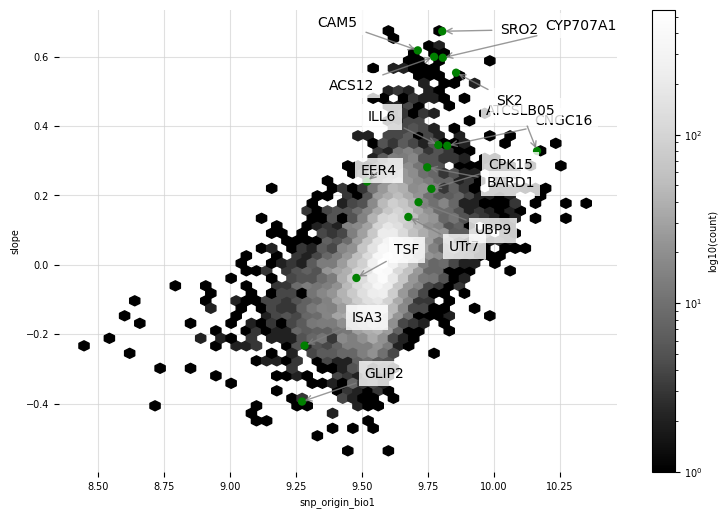

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=(9, 6))

# Create a hexbin plot with a color bar
hb = ax.hexbin(
    wza_binomial_regression_bio1['snp_origin_bio1'],
    wza_binomial_regression_bio1['slope'],
    gridsize=50,  # Size of the hexagons
    cmap='Greys_r',  # Color map for the hexbins
    bins='log',  # Use logarithmic counts for coloring
    mincnt=1  # Minimum count number to display a hexagon
)

# Create a color bar for the hexbin plot
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')

# Filter the data where 'sign' is True
significant_points = wza_binomial_regression_bio1[wza_binomial_regression_bio1['sign'] == True]

# Overlay scatter plot for significant points
ax.scatter(
    significant_points['snp_origin_bio1'],
    significant_points['slope'],
    color='Green',  # Red color for significant points
    #label='Significant',  # Label for legend
    alpha=1,  # Some transparency
    edgecolor='none',  # No edge color
)

# Prepare list to store text objects for adjustment
texts = []
for i, row in significant_points.iterrows():
    texts.append(ax.text(
        row['snp_origin_bio1'],
        row['slope'],
        row['gene_name'],
        ha='center',
        va='bottom',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)  # Background box for text
    ))

# Use adjust_text to dynamically adjust the text positions

adjust_text(texts, 
            expand_points=(4, 4),  
            only_move={'text':'y+'},
            arrowprops=dict(arrowstyle='->', color='gray', lw=1, alpha=0.8))

dark_grey = '#4D4D4D'  # Define dark grey color
plt.grid(True, color='lightgrey', alpha=0.7, zorder=0)

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Set labels and title
ax.set_xlabel('snp_origin_bio1')
ax.set_ylabel('slope')
#ax.set_title('Density of Points with Hexbin Plot')

# Add a legend to the plot
#ax.legend(title='Point Significance')
plt.savefig('blocks_across_space.pdf')
plt.show()
